# Basics of _Dynamic PET_

This notebook illustrates basic image input/output functionality of
[_Dynamic PET_].

[_Dynamic PET_]: https://github.com/bilgelm/dynamicpet

First, we download a 4-D PET image with its [PET-BIDS] json sidecar from
[OpenNeuro](https://openneuro.org/):

[PET-BIDS]: https://bids-specification.readthedocs.io/en/stable/modality-specific-files/positron-emission-tomography.html

In [1]:
from pathlib import Path

import requests


outdir = Path.cwd() / "nb_data"
outdir.mkdir(exist_ok=True)

petjson_fname = outdir / "pet.json"
pet_fname = outdir / "pet.nii"

baseurl = "https://s3.amazonaws.com/openneuro.org/ds001705/sub-000101/ses-baseline/"

peturl = (
    baseurl
    + "pet/sub-000101_ses-baseline_pet.nii"
    + "?versionId=rMjWUWxAIYI46DmOQjulNQLTDUAThT5o"
)

if not petjson_fname.exists():
    r = requests.get(
        baseurl
        + "pet/sub-000101_ses-baseline_pet.json"
        + "?versionId=Gfkc8Y71JexOLZq40ZN4BTln_4VObTJR",
        timeout=10,
    )
    r.raise_for_status()
    with open(petjson_fname, "wb") as f:
        f.write(r.content)

if not pet_fname.exists():
    with requests.get(peturl, timeout=10, stream=True) as r:
        r.raise_for_status()
        with open(pet_fname, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

## Load 4-D PET image

We read in this 4-D PET image (and its accompanying json) using the `load`
function from `dynamicpet.petbids.petbidsimage`:

In [2]:
from dynamicpet.petbids.petbidsimage import load


pet = load(pet_fname)

## Basic attributes/properties

The variable `pet` is an instance of _Dynamic PET_'s `PETBIDSImage` class.
This object stores image data in an attribute called `img` (i.e., `pet.img`),
which is an instance of a subclass of `nibabel.spatialimages.SpatialImage`.
(In this example, it happens to be an `nibabel.nifti1.Nifti1Image`.)
We can get the dimensions of the 4-D image (3-D image dimensions and number of
time frames) using the `shape` property:

In [3]:
pet.shape

(182, 218, 182, 23)

The variable `pet` also stores the PET-BIDS json as a dictionary, in an
attribute called `json_dict`:

In [4]:
pet.json_dict

{'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Biograph mMr',
 'Units': 'kBq/mL',
 'TracerName': 'LondonPride',
 'TracerRadionuclide': 'C11',
 'BodyPart': 'brain',
 'InjectedRadioactivity': 400.0,
 'InjectedRadioactivityUnits': 'MBq',
 'InjectedMass': 5.0,
 'InjectedMassUnits': 'ug',
 'SpecificRadioactivity': 35.0,
 'SpecificRadioactivityUnits': 'GBq/ug',
 'ModeOfAdministration': 'bolus',
 'TimeZero': '09:45:00',
 'ScanStart': 0,
 'InjectionStart': 0,
 'FrameTimesStart': [0,
  15,
  30,
  45,
  60,
  120,
  180,
  240,
  300,
  450,
  600,
  900,
  1200,
  1500,
  1800,
  2100,
  2400,
  2700,
  3000,
  3300,
  3600,
  4200,
  4800],
 'FrameDuration': [15,
  15,
  15,
  15,
  60,
  60,
  60,
  60,
  150,
  150,
  300,
  300,
  300,
  300,
  300,
  300,
  300,
  300,
  300,
  300,
  600,
  600,
  600],
 'InjectionEnd': 30,
 'AcquisitionMode': '3D',
 'ImageDecayCorrected': True,
 'ImageDecayCorrectionTime': 0,
 'ReconMethodName': 'MLEM',
 'ReconMethodParameterLabels': ['iteratio

## Frame timing information

_Dynamic PET_ includes properties/functions such as
`frame_start`, `frame_end`, `frame_mid`, `frame_duration`
to extract frame timing information.

:exclamation: Note: the default unit in PET-BIDS json files is seconds.
_Dynamic PET_ converts these to minutes, so all of the timing functions in
_Dynamic PET_ return values in minutes.

_Dynamic PET_ internally performs certain data checks, so using these
properties/functions are preferred over directly extracting the values from the
json files.

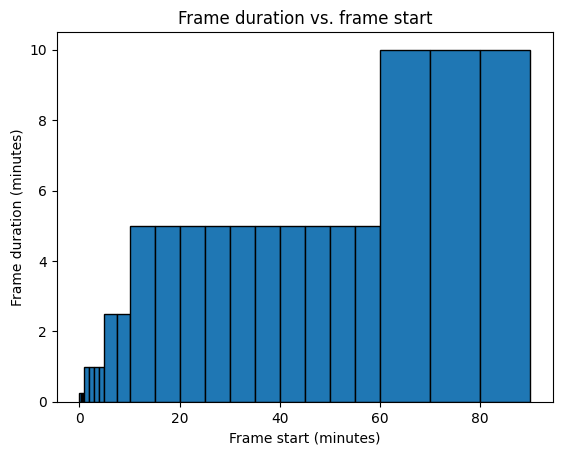

In [5]:
import matplotlib.pyplot as plt


plt.figure()
plt.bar(
    pet.frame_start,
    pet.frame_duration,
    width=pet.frame_duration,
    edgecolor="black",
    align="edge",
)
plt.xlabel("Frame start (minutes)")
plt.ylabel("Frame duration (minutes)")
plt.title("Frame duration vs. frame start");

## Basic visualization

We find and plot the first 5-minute long frame using `nilearn`:

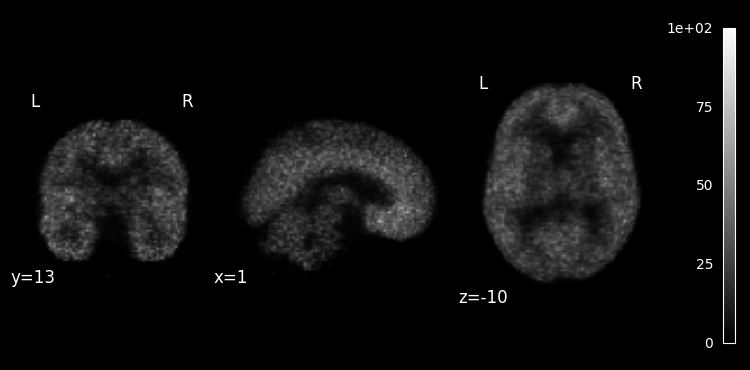

In [6]:
from nilearn import plotting
from nilearn.image import index_img


frame_index = (pet.frame_duration == 5).argmax()
plotting.plot_anat(index_img(pet.img, frame_index), colorbar=True, draw_cross=False);

We can also plot a weighted mean of all time frames, where each frame is
weighted according to its duration:

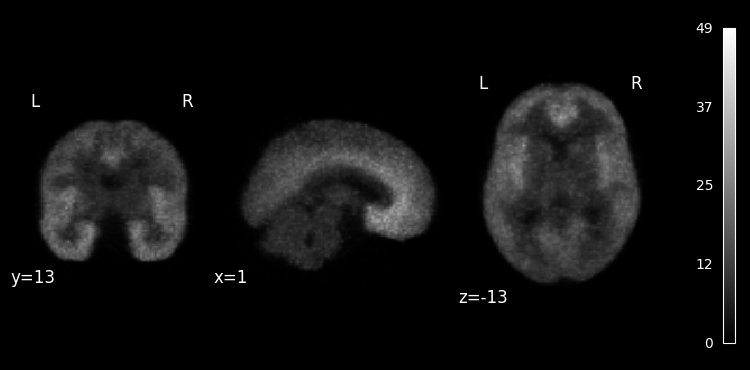

In [7]:
plotting.plot_anat(
    pet.dynamic_mean(weight_by="frame_duration"),
    colorbar=True,
    draw_cross=False,
);

## Time activity curve

We can extract the time series data (called the time activity curve, or TAC) for
a single voxel:

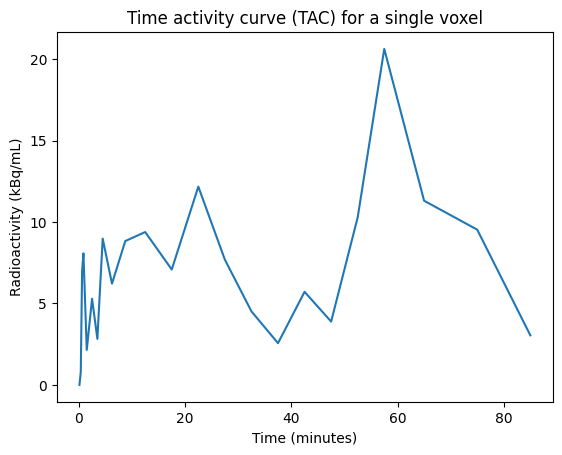

In [8]:
voxel_index = (100, 100, 100)  # an arbitrarily selected voxel

voxel_tac = pet.dataobj[*voxel_index, ...]
time = pet.frame_mid

plt.figure()
plt.plot(time, voxel_tac)
plt.xlabel("Time (minutes)")
plt.ylabel(f'Radioactivity ({pet.json_dict["Units"]})')
plt.title("Time activity curve (TAC) for a single voxel");

## Temporal split

We can split the 4-D PET image (in time).
This operation splits the data matrix and generates PET-BIDS jsons for the split
images, and yields two `PETBIDSImage` objects.

In [9]:
pet_0to60, pet_60to90 = pet.split(split_time=60)  # split_time specified in min

In [10]:
pet_60to90.json_dict

{'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Biograph mMr',
 'Units': 'kBq/mL',
 'TracerName': 'LondonPride',
 'TracerRadionuclide': 'C11',
 'BodyPart': 'brain',
 'InjectedRadioactivity': 400.0,
 'InjectedRadioactivityUnits': 'MBq',
 'InjectedMass': 5.0,
 'InjectedMassUnits': 'ug',
 'SpecificRadioactivity': 35.0,
 'SpecificRadioactivityUnits': 'GBq/ug',
 'ModeOfAdministration': 'bolus',
 'TimeZero': '09:45:00',
 'ScanStart': 0,
 'InjectionStart': 0,
 'FrameTimesStart': [3600.0, 4200.0, 4800.0],
 'FrameDuration': [600.0, 600.0, 600.0],
 'InjectionEnd': 30,
 'AcquisitionMode': '3D',
 'ImageDecayCorrected': True,
 'ImageDecayCorrectionTime': 0,
 'ReconMethodName': 'MLEM',
 'ReconMethodParameterLabels': ['iterations'],
 'ReconMethodParameterUnits': ['none'],
 'ReconMethodParameterValues': [100],
 'ReconFilterType': 'PSF',
 'ReconFilterSize': 2.5,
 'AttenuationCorrection': 'Activity decay corrected'}

## Save 4-D PET image

We save the 60-to-90 min image (along with its PET-BIDS json):

In [11]:
out_fname = pet_fname.with_name(pet_fname.stem + "_60to90min").with_suffix(
    pet_fname.suffix
)
pet.to_filename(out_fname)